In [51]:
#Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.layers import GRU, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose



In [52]:
#Settings
TRAIN_SZ = 0.7
VAL_SZ = 0.15
TEST_SZ = 0.15
FOLD_SZ = 4
LAGS_SZ = 8
H_FORECAST = 1
L_RATE = 0.005

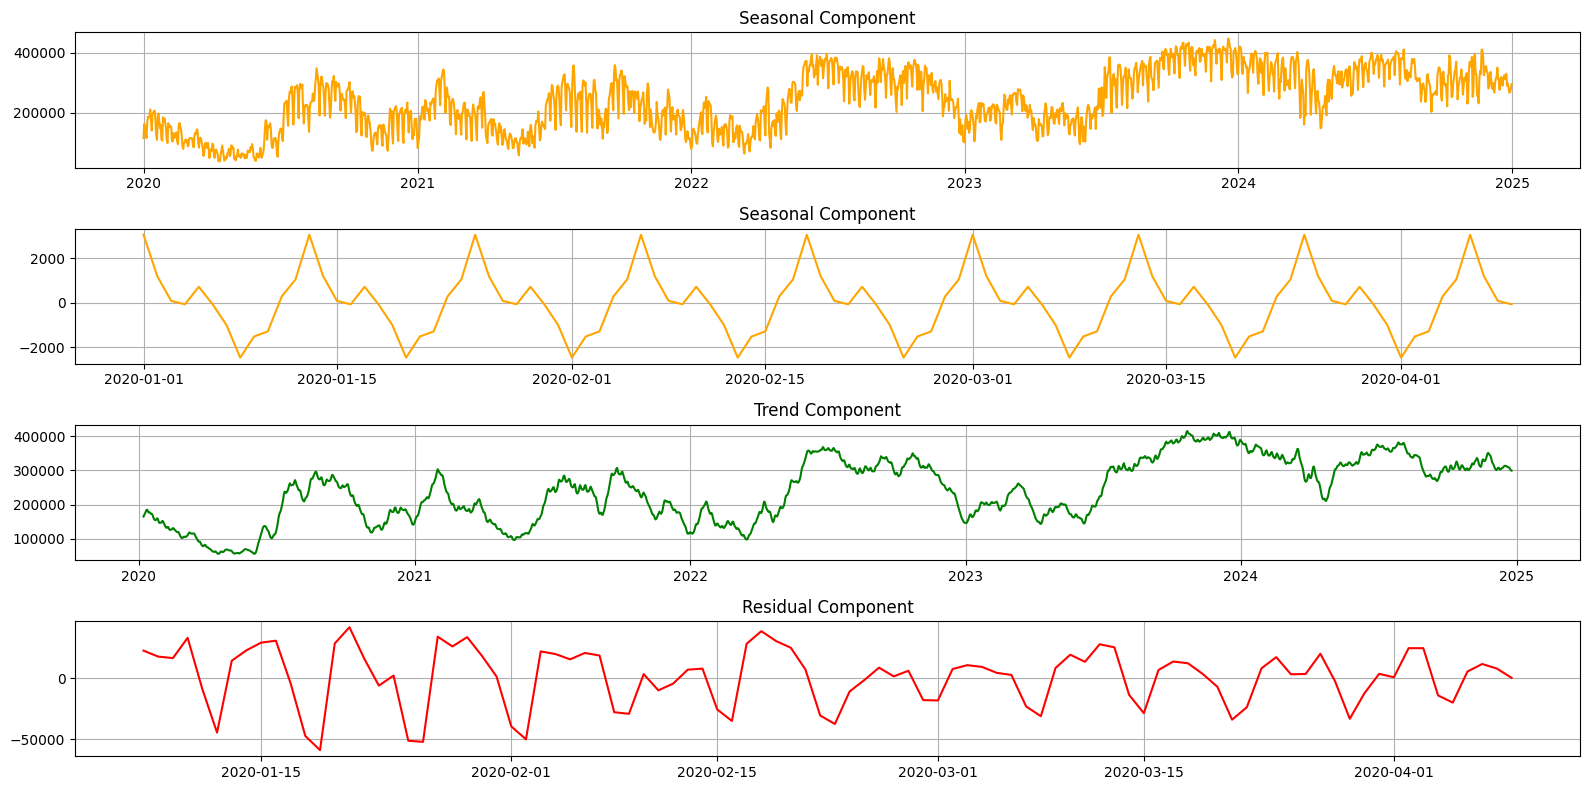

In [ ]:
#Consumption dataframe
df_consumo = pd.read_csv(r"consumo_energia.csv")
df_consumo['date'] = pd.to_datetime(df_consumo['din_instante'])
df_consumo.set_index('date', inplace=True)
df_consumo.sort_index(inplace=True)
df_consumo.drop(['id_subsistema'],axis=1)

#Generation dataframe
df_geracao = pd.read_csv(r"geracao_energia.csv")
df_geracao['date'] = pd.to_datetime(df_geracao['index'])
df_geracao.set_index('date', inplace=True)
df_geracao['month'] = df_geracao.index.month
df_geracao['weekday'] = df_geracao.index.weekday
df_geracao.sort_index(inplace=True)

merged_df = pd.merge(df_geracao, df_consumo, on='date')

result = seasonal_decompose(merged_df['val_geracao'], model='additive', period=48)

seasonal = merged_df['seasonal'] = result.seasonal
trend = merged_df['seasonal'] = result.trend
residual = merged_df['seasonal'] = result.resid

#Consumption dataframe
df_consumo = pd.read_csv(r"consumo_energia.csv")
df_consumo['date'] = pd.to_datetime(df_consumo['din_instante'])
df_consumo.set_index('date', inplace=True)
df_consumo.sort_index(inplace=True)
df_consumo.drop(['id_subsistema'],axis=1)

#Generation dataframe
df_geracao = pd.read_csv(r"geracao_energia.csv")
df_geracao['date'] = pd.to_datetime(df_geracao['index'])
df_geracao.set_index('date', inplace=True)
df_geracao['month'] = df_geracao.index.month
df_geracao['weekday'] = df_geracao.index.weekday
df_geracao.sort_index(inplace=True)

merged_df = pd.merge(df_geracao, df_consumo, on='date')

result = seasonal_decompose(merged_df['val_geracao'], model='additive', period=12)

seasonal = merged_df['seasonal'] = result.seasonal
trend = merged_df['seasonal'] = result.trend
residual = merged_df['seasonal'] = result.resid

plt.figure(figsize=(16, 8))

plt.subplot(4, 1, 1)
plt.plot(merged_df['val_geracao'], label='Seasonal', color='orange')
plt.title('Seasonal Component')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(seasonal[:100], label='Seasonal', color='orange')
plt.title('Seasonal Component')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(trend, label='Trend', color='green')
plt.title('Trend Component')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(residual[:100], label='Residual', color='red')
plt.title('Residual Component')
plt.grid(True)

plt.tight_layout()
plt.show()

In [54]:
#Data Preprocessing
df = merged_df

# Seleção de colunas e normalização
df = df[['index', 'month', 'weekday', 'val_geracao', 'val_cargaenergiamwmed','seasonal']]

#Divind Train and Test, the cross validation will be applied to the train set
train_set = df[:1516]
test_set = df[1516:] # will be used at the end of each model training and at the end for the meta model validation

#Z-Score Standarization
scaler = StandardScaler()
train_set['val_geracao_norm'] = scaler.fit_transform(train_set[['val_geracao']])
train_set['val_cargaenergiamwmed_norm'] = scaler.fit_transform(train_set[['val_cargaenergiamwmed']])
train_set['month_norm'] = scaler.fit_transform(train_set[['month']])
train_set['weekday_norm'] = scaler.fit_transform(train_set[['weekday']])
train_set['seasonal_norm'] = scaler.fit_transform(train_set[['seasonal']])

#defininf dependent and idependent variables
predictors = train_set[['month_norm','weekday_norm','val_geracao_norm','val_cargaenergiamwmed_norm','seasonal_norm']]
predicted = predictors[['val_geracao_norm']]


#Creating sequences
X, y = [], []
data_np = predictors.to_numpy()
pred_np = predicted.to_numpy()
for i in range(len(data_np) - LAGS_SZ - H_FORECAST + 1):
    X.append(data_np[i:i+LAGS_SZ])
    y.append(pred_np[i+LAGS_SZ:i+LAGS_SZ+H_FORECAST])

X = np.array(X)
y = np.array(y)
# KFold sobre os dados de treino/validação
kf = KFold(n_splits=FOLD_SZ, shuffle=False)

X_train_folds = []
X_test_folds = []
y_train_folds = []
y_test_folds = []

for train_index, test_index in kf.split(X):
    X_train_fold = X[train_index]
    X_test_fold = X[test_index]
    y_train_fold = y[train_index]
    y_test_fold = y[test_index]

    X_train_folds.append(X_train_fold)
    X_test_folds.append(X_test_fold)
    y_train_folds.append(y_train_fold)
    y_test_folds.append(y_test_fold)

C:\Users\mateu\AppData\Local\Temp\ipykernel_7384\1189793757.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['val_geracao_norm'] = scaler.fit_transform(train_set[['val_geracao']])
C:\Users\mateu\AppData\Local\Temp\ipykernel_7384\1189793757.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['val_cargaenergiamwmed_norm'] = scaler.fit_transform(train_set[['val_cargaenergiamwmed']])
C:\Users\mateu\AppData\Local\Temp\ipykernel_7384\1189793757.py:15: SettingWithCopyWarning: 
A value is t

Text(0.5, 1.0, 'Generation PACF Plot')

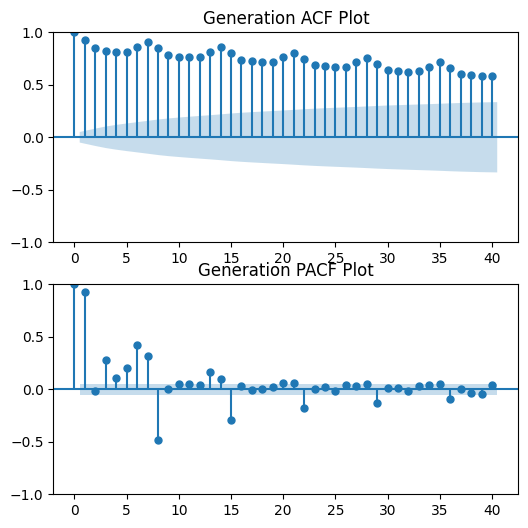

In [55]:
#Generation and Consumptionm ACF and PACF
fig, ax,  = plt.subplots(2, 1, figsize=(6, 6))
plot_acf(predicted, ax=ax[0], lags=40)
ax[0].set_title("Generation ACF Plot")
plot_pacf(predicted, ax=ax[1], lags=40, method='ywm')
ax[1].set_title("Generation PACF Plot")

In [56]:
#Models definition

#Buildintg the LSTM architecture
def build_lstm(input_shape, learning_rate):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
    return model
    
#Buildintg the GRU architecture
def build_gru(input_shape, learning_rate):
    model = Sequential()
    model.add(GRU(64, input_shape=input_shape))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
    return model

#Buildintg the XGBoost architecture
def build_xgboost():
    model = xgb.XGBRegressor(objective='reg:squarederror',
                             colsample_bytree=0.4603, 
                             gamma=0.0468, 
                             learning_rate=0.005, 
                             max_depth=3, 
                             min_child_weight=1.7817, 
                             n_estimators=2200,
                             reg_alpha=0.4640, 
                             reg_lambda=0.8571,
                             subsample=0.5213, 
                             verbosity=1,
                             random_state =7, 
                             nthread = -1)
    return model

#Building a CNN architecture
def build_cnn(input_shape, learning_rate):
    model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
    return model

# ------------------------ Meta Learner ----------------------- #

def build_rf():
    return LinearSVR()


In [57]:
#list of models
xgb_trained  = []
cnn_trained  = []
gru_trained  = []
lstm_trained = []

# Prediction that are composing the meta learner training set
xgb_preds  = []
cnn_preds  = []
gru_preds  = []
lstm_preds = []

In [58]:
#Eval function
def print_metrics(y_true, y_pred, model_name, fold):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f'\n📊 Fold {fold} - {model_name}:\n'
          f'   MSE:  {mse:.4f}\n'
          f'   RMSE: {rmse:.4f}\n'
          f'   MAPE: {mape:.4f}\n')

fold X 1 de treino: (1131, 8, 5) e fold 1 X de teste: (377, 8, 5)
fold y 1 de treino: (1131, 1, 1) e fold 1 y de teste: (377, 1, 1)
 -------------------------------------- Treinando o fold 1 da rede LSTM -------------------------------------- 
Epoch 1/50


c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5432 - root_mean_squared_error: 0.7191
Epoch 1: saving model to models/lstm_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4666 - root_mean_squared_error: 0.6642
Epoch 2/50
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1451 - root_mean_squared_error: 0.3808
Epoch 2: saving model to models/lstm_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1426 - root_mean_squared_error: 0.3775
Epoch 3/50
25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1137 - root_mean_squared_error: 0.3369
Epoch 3: saving model to models/lstm_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1137 - root_mean_squared_error: 0.3370
Epoch 4/50
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0819 - root_mean_squared_error: 0.2860
Epoch 4: saving model to models/lstm_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0826 - root_mean_squared_error: 0.2872
Epoch 5/50
29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3971 - root_mean_squared_error: 0.6130
Epoch 1: saving model to models/cnn_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3927 - root_mean_squared_error: 0.6095
Epoch 2/50
20/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1518 - root_mean_squared_error: 0.3891 
Epoch 2: saving model to models/cnn_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1398 - root_mean_squared_error: 0.3732
Epoch 3/50
18/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0957 - root_mean_squared_error: 0.3093 
Epoch 3: saving model to models/cnn_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0972 - root_mean_squared_error: 0.3118
Epoch 4/50
18/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0919 - root_mean_squared_error: 0.3029 
Epoch 4: saving model to models/cnn_fold_1.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0937 - root_mean_squared_error: 0.3059
Epoch 5/50
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4486 - root_mean_squared_error: 0.6514
Epoch 1: saving model to models/lstm_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3856 - root_mean_squared_error: 0.6023
Epoch 2/50
34/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1132 - root_mean_squared_error: 0.3364
Epoch 2: saving model to models/lstm_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1136 - root_mean_squared_error: 0.3369
Epoch 3/50
25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1010 - root_mean_squared_error: 0.3175
Epoch 3: saving model to models/lstm_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1004 - root_mean_squared_error: 0.3167
Epoch 4/50
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0889 - root_mean_squared_error: 0.2982
Epoch 4: saving model to models/lstm_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0873 - root_mean_squared_error: 0.2954
Epoch 5/50
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4911 - root_mean_squared_error: 0.6855   
Epoch 1: saving model to models/cnn_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3785 - root_mean_squared_error: 0.5983
Epoch 2/50
22/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1179 - root_mean_squared_error: 0.3432 
Epoch 2: saving model to models/cnn_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1145 - root_mean_squared_error: 0.3382
Epoch 3/50
23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0880 - root_mean_squared_error: 0.2965 
Epoch 3: saving model to models/cnn_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0891 - root_mean_squared_error: 0.2984
Epoch 4/50
23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0845 - root_mean_squared_error: 0.2907 
Epoch 4: saving model to models/cnn_fold_2.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0858 - root_mean_squared_error: 0.2929
Epoch 5/50
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5430 - root_mean_squared_error: 0.7142
Epoch 1: saving model to models/lstm_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4785 - root_mean_squared_error: 0.6687
Epoch 2/50
30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1362 - root_mean_squared_error: 0.3689
Epoch 2: saving model to models/lstm_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1346 - root_mean_squared_error: 0.3667
Epoch 3/50
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1194 - root_mean_squared_error: 0.3452
Epoch 3: saving model to models/lstm_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1160 - root_mean_squared_error: 0.3402
Epoch 4/50
25/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0919 - root_mean_squared_error: 0.3027
Epoch 4: saving model to models/lstm_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0891 - root_mean_squared_error: 0.2981
Epoch 5/50
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4490 - root_mean_squared_error: 0.6585   
Epoch 1: saving model to models/cnn_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3541 - root_mean_squared_error: 0.5832
Epoch 2/50
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1169 - root_mean_squared_error: 0.3419
Epoch 2: saving model to models/cnn_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1170 - root_mean_squared_error: 0.3419
Epoch 3/50
23/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0964 - root_mean_squared_error: 0.3103 
Epoch 3: saving model to models/cnn_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0980 - root_mean_squared_error: 0.3129
Epoch 4/50
20/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0974 - root_mean_squared_error: 0.3120 
Epoch 4: saving model to models/cnn_fold_3.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0952 - root_mean_squared_error: 0.3085
Epoch 5/50
21/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2626 - root_mean_squared_error: 0.5056
Epoch 1: saving model to models/lstm_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2585 - root_mean_squared_error: 0.5017
Epoch 2/50
30/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1205 - root_mean_squared_error: 0.3470
Epoch 2: saving model to models/lstm_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1193 - root_mean_squared_error: 0.3452
Epoch 3/50
33/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0875 - root_mean_squared_error: 0.2956
Epoch 3: saving model to models/lstm_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0867 - root_mean_squared_error: 0.2942
Epoch 4/50
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0659 - root_mean_squared_error: 0.2565
Epoch 4: saving model to models/lstm_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0661 - root_mean_squared_error: 0.2568
Epoch 5/50
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4249 - root_mean_squared_error: 0.6338
Epoch 1: saving model to models/cnn_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3838 - root_mean_squared_error: 0.6015
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1160 - root_mean_squared_error: 0.3405
Epoch 2: saving model to models/cnn_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1159 - root_mean_squared_error: 0.3404
Epoch 3/50
26/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0963 - root_mean_squared_error: 0.3101
Epoch 3: saving model to models/cnn_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0966 - root_mean_squared_error: 0.3106
Epoch 4/50
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0970 - root_mean_squared_error: 0.3114
Epoch 4: saving model to models/cnn_fold_4.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0953 - root_mean_squared_error: 0.3085
Epoch 5/50
28/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

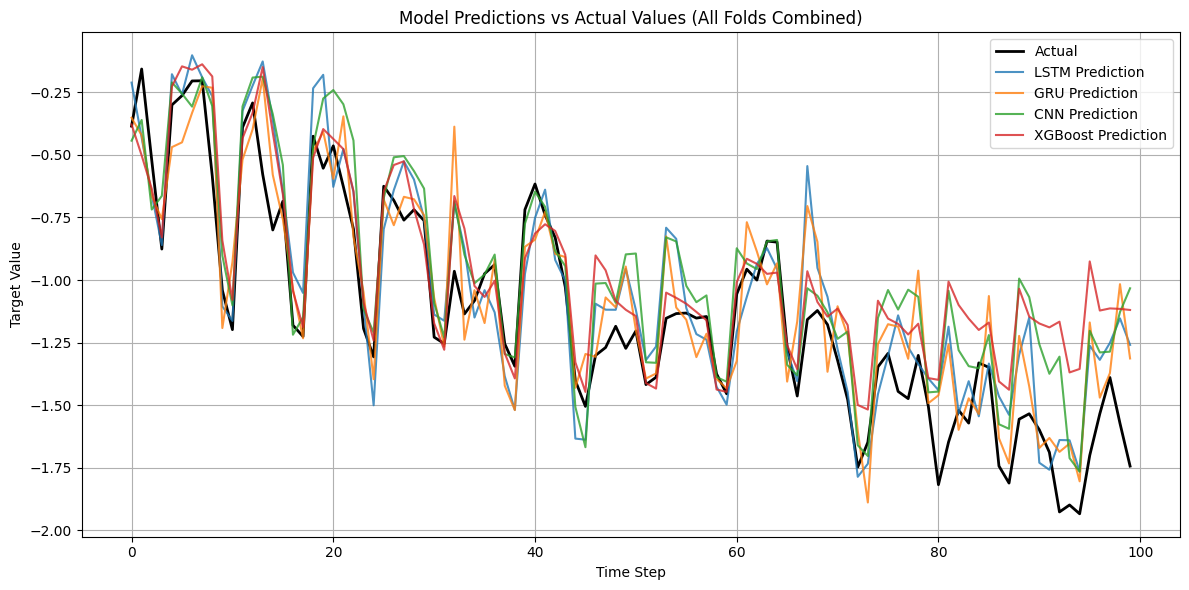

In [59]:
# CV loop for training
for i in range(FOLD_SZ):
    print(f'fold X {i+1} de treino: {X_train_folds[i].shape} e fold {i+1} X de teste: {X_test_folds[i].shape}')
    print(f'fold y {i+1} de treino: {y_train_folds[i].shape} e fold {i+1} y de teste: {y_test_folds[i].shape}')


    #Training the lstm net
    print(f' -------------------------------------- Treinando o fold {i+1} da rede LSTM -------------------------------------- ')
    lstm = build_lstm(X_train_folds[i].shape[1:], L_RATE)
    checkpoint = ModelCheckpoint(f'models/lstm_fold_{i+1}.weights.h5', save_weights_only=True, verbose = 1)
    lstm.fit(X_train_folds[i], y_train_folds[i], epochs=50, callbacks = checkpoint)

    #Training the gru net
    print(f' -------------------------------------- Treinando o fold {i+1} da rede GRU -------------------------------------- ')
    gru  = build_gru(  X_train_folds[i].shape[1:],L_RATE)
    checkpoint_gru = ModelCheckpoint(f'models/gru_fold_{i+1}.weights.h5', save_weights_only=True, verbose = 1)
    gru.fit(X_train_folds[i], y_train_folds[i], epochs=50, callbacks = checkpoint_gru)

    #Training the cnn net
    print(f' -------------------------------------- Treinando o fold {i+1} da rede CNN -------------------------------------- ')
    cnn  = build_cnn( X_train_folds[i].shape[1:],L_RATE)
    checkpoint_cnn = ModelCheckpoint(f'models/cnn_fold_{i+1}.weights.h5', save_weights_only=True, verbose = 1)
    cnn.fit(X_train_folds[i], y_train_folds[i], epochs=50, callbacks = checkpoint_cnn)

    #Training the xgboost net
    print(f' -------------------------------------- Treinando o fold {i+1} da rede XGB --------------------------------------')
    xgb_model = build_xgboost()  # renamed from xgb
    xgb_model.fit(
        X_train_folds[i].reshape(X_train_folds[i].shape[0], -1),
        y_train_folds[i].squeeze(),
        verbose=True
    )
    xgb_model.save_model(f'models/xbg_fold_{i+1}.json')

    #Saving the models
    lstm_trained.append(lstm)
    print(lstm_trained)

    gru_trained.append(gru)
    print(gru_trained)

    cnn_trained.append(cnn)
    print(cnn_trained)

    xgb_trained.append(xgb)
    print(xgb_trained)

    lstm_pred = lstm.predict(X_test_folds[i])
    gru_pred  = gru.predict(X_test_folds[i])
    cnn_pred  = cnn.predict(X_test_folds[i])
    xgb_pred  = xgb_model.predict(X_test_folds[i].reshape(X_test_folds[i].shape[0], -1))

    # Save predictions
    lstm_preds.append(lstm_pred)
    gru_preds.append(gru_pred)
    cnn_preds.append(cnn_pred)
    xgb_preds.append(xgb_pred)

    # Calculate and print metrics
    y_true = y_test_folds[i].squeeze()
    print_metrics(y_true, lstm_pred.squeeze(), 'LSTM', i+1)
    print_metrics(y_true, gru_pred.squeeze(),  'GRU',  i+1)
    print_metrics(y_true, cnn_pred.squeeze(),  'CNN',  i+1)
    print_metrics(y_true, xgb_pred.squeeze(),  'XGBoost', i+1)

# Concatenate predictions and actual values from all folds
y_test_all = np.concatenate(y_test_folds).squeeze()
lstm_all   = np.concatenate(lstm_preds).squeeze()
gru_all    = np.concatenate(gru_preds).squeeze()
cnn_all    = np.concatenate(cnn_preds).squeeze()
xgb_all    = np.concatenate(xgb_preds).squeeze()

# Plot all predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_all[:100], label='Actual', color='black', linewidth=2)
plt.plot(lstm_all[:100], label='LSTM Prediction', alpha=0.8)
plt.plot(gru_all[:100], label='GRU Prediction', alpha=0.8)
plt.plot(cnn_all[:100], label='CNN Prediction', alpha=0.8)
plt.plot(xgb_all[:100], label='XGBoost Prediction', alpha=0.8)

plt.title('Model Predictions vs Actual Values (All Folds Combined)')
plt.xlabel('Time Step')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
#training Meta Model
df_meta_model = pd.DataFrame({
    'xgb': xgb_all,
    'cnn': cnn_all,
    'gru': gru_all,
    'lstm': lstm_all,
    'actual':y_test_all
})

train = df_meta_model

predictors = train[['xgb','cnn','gru','lstm','actual']]
predicted = train[['actual']]

X_train, y_train = [], []
data_np = predictors.to_numpy()
pred_np = predicted.to_numpy()
for i in range(len(data_np) - LAGS_SZ - H_FORECAST + 1):
    X_train.append(data_np[i:i+LAGS_SZ])
    y_train.append(pred_np[i+LAGS_SZ:i+LAGS_SZ+H_FORECAST])

X_train = np.array(X_train)
y_train = np.array(y_train)

X_train_flat = X_train.reshape(X_train.shape[0], -1)
y_train_flat = y_train.reshape(y_train.shape[0], -1)

rf = build_rf()
rf.fit(X_train_flat, y_train_flat.ravel()) 

c:\Users\mateu\OneDrive\Área de Trabalho\MESTRADO_2025\PPREVISÃO DE SERIES TEMPORAIS\SEL-for-Energy-Generation-Forecasting\sel\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'
,fit_intercept,True
,intercept_scaling,1.0
,dual,'auto'
,verbose,0
,random_state,None
,max_iter,1000


In [61]:
#preprocess test data

#Z-Score Standarization
scaler = StandardScaler()
test_set['val_geracao_norm'] = scaler.fit_transform(test_set[['val_geracao']])
test_set['val_cargaenergiamwmed_norm'] = scaler.fit_transform(test_set[['val_cargaenergiamwmed']])
test_set['month_norm'] = scaler.fit_transform(test_set[['month']])
test_set['weekday_norm'] = scaler.fit_transform(test_set[['weekday']])
test_set['seasonal_norm'] = scaler.fit_transform(test_set[['seasonal']])

#defining dependent and idependent variables
test_predictors = test_set[['month_norm', 'weekday_norm', 'val_geracao_norm', 'val_cargaenergiamwmed_norm','seasonal_norm']]
test_predicted = test_predictors[['val_geracao_norm']]

#Creating Sequences
X_test_final, y_test_final = [], []
data_test_np = test_predictors.to_numpy()
pred_test_np = test_predicted.to_numpy()

for i in range(len(data_test_np) - LAGS_SZ - H_FORECAST + 1):
    X_test_final.append(data_test_np[i:i+LAGS_SZ])
    y_test_final.append(pred_test_np[i+LAGS_SZ:i+LAGS_SZ+H_FORECAST])

X_test_final = np.array(X_test_final)
y_test_final = np.array(y_test_final)

# # Rebuild and load weights
# lstm = build_lstm(X_test_final.shape[1:], L_RATE)
# gru = build_gru(X_test_final.shape[1:], L_RATE)
# cnn = build_cnn(X_test_final.shape[1:], L_RATE)
# xgb_model = build_xgboost()

lstm.load_weights('models/lstm_fold_2.weights.h5')
gru.load_weights('models/gru_fold_2.weights.h5')
cnn.load_weights('models/cnn_fold_2.weights.h5')
xgb_model.load_model('models/xbg_fold_2.json')

# Predict
y_pred_lstm = lstm.predict(X_test_final)
y_pred_gru  = gru.predict(X_test_final)
y_pred_cnn  = cnn.predict(X_test_final)
y_pred_xgb  = xgb_model.predict(X_test_final.reshape(X_test_final.shape[0], -1))


def print_metrics(y_true, y_pred, model_name, fold=None):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)


    fold_info = f" | Fold {fold}" if fold is not None else ""
    print(f"{model_name}{fold_info} -> MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2f}%")

print_metrics(y_test_final, y_pred_lstm, 'LSTM')
print_metrics(y_test_final, y_pred_gru,  'GRU')
print_metrics(y_test_final, y_pred_cnn,  'CNN')
print_metrics(y_test_final, y_pred_xgb,  'XGBoost')

C:\Users\mateu\AppData\Local\Temp\ipykernel_7384\1812096686.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['val_geracao_norm'] = scaler.fit_transform(test_set[['val_geracao']])
C:\Users\mateu\AppData\Local\Temp\ipykernel_7384\1812096686.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['val_cargaenergiamwmed_norm'] = scaler.fit_transform(test_set[['val_cargaenergiamwmed']])
C:\Users\mateu\AppData\Local\Temp\ipykernel_7384\1812096686.py:7: SettingWithCopyWarning: 
A value is trying t

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LSTM -> MSE: 0.3371 | RMSE: 0.5806 | MAPE: 2.79%
GRU -> MSE: 0.3816 | RMSE: 0.6178 | MAPE: 3.58%
CNN -> MSE: 0.3614 | RMSE: 0.6011 | MAPE: 2.58%
XGBoost -> MSE: 0.3744 | RMSE: 0.6119 | MAPE: 2.62%


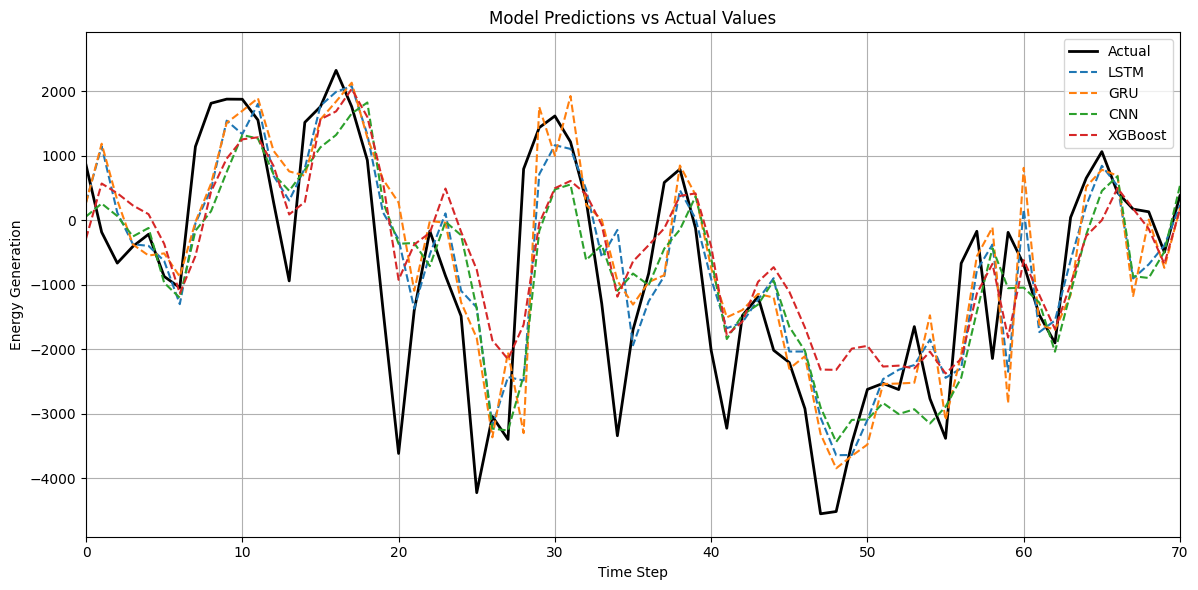

In [62]:
#Ploting data
y_true = y_test_final.reshape(-1)
y_lstm = y_pred_lstm.reshape(-1)
y_gru  = y_pred_gru.reshape(-1)
y_cnn  = y_pred_cnn.reshape(-1)
y_xgb  = y_pred_xgb.reshape(-1)

y_true_orig = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
y_lstm_orig = scaler.inverse_transform(y_lstm.reshape(-1, 1)).flatten()
y_gru_orig  = scaler.inverse_transform(y_gru.reshape(-1, 1)).flatten()
y_cnn_orig  = scaler.inverse_transform(y_cnn.reshape(-1, 1)).flatten()
y_xgb_orig  = scaler.inverse_transform(y_xgb.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 6))

plt.plot(y_true_orig, label='Actual', color='black', linewidth=2)
plt.plot(y_lstm_orig, label='LSTM', linestyle='--')
plt.plot(y_gru_orig, label='GRU', linestyle='--')
plt.plot(y_cnn_orig, label='CNN', linestyle='--')
plt.plot(y_xgb_orig, label='XGBoost', linestyle='--')

plt.title('Model Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Energy Generation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(0, 70)
plt.show()

In [63]:
#passing it to the SVR meta model
y_pred_lstm = lstm.predict(X_test_final)       # shape: (samples, steps)
y_pred_gru  = gru.predict(X_test_final)
y_pred_cnn  = cnn.predict(X_test_final)
y_pred_xgb  = xgb_model.predict(X_test_final.reshape(X_test_final.shape[0], -1))  # shape: (samples,)

# Flatten each prediction if needed
lstm_preds_flat = y_pred_lstm.reshape(-1)
gru_preds_flat  = y_pred_gru.reshape(-1)
cnn_preds_flat  = y_pred_cnn.reshape(-1)
xgb_preds_flat  = y_pred_xgb.reshape(-1)
y_true_flat     = y_test_final.reshape(-1)

# Meta model input
df_meta_input = pd.DataFrame({
    'lstm': lstm_preds_flat,
    'gru': gru_preds_flat,
    'cnn': cnn_preds_flat,
    'xgb': xgb_preds_flat,
    'actual': y_true_flat
})

predictors = df_meta_input[['xgb','cnn','gru','lstm','actual']]
predicted = df_meta_input[['actual']]

X_tst, y_tst = [], []
data_np = predictors.to_numpy()
pred_np = predicted.to_numpy()
for i in range(len(data_np) - LAGS_SZ - H_FORECAST + 1):
    X_tst.append(data_np[i:i+LAGS_SZ])
    y_tst.append(pred_np[i+LAGS_SZ:i+LAGS_SZ+H_FORECAST])

X_tst = np.array(X_tst)
y_tst = np.array(y_tst)

X_tst_flat = X_tst.reshape(X_tst.shape[0], -1)
y_tst_flat = y_tst.reshape(y_tst.shape[0], -1)

meta_pred = rf.predict(X_tst_flat)

y_true = y_tst_flat.reshape(-1)
y_pred = meta_pred.reshape(-1)

def print_metrics(y_true, y_pred, name='Model'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f'📊 Metrics for {name}:')
    print(f'  MSE:  {mse:.4f}')
    print(f'  RMSE: {rmse:.4f}')
    print(f'  MAPE: {mape:.4f}%')

print_metrics(y_true, y_pred, 'SVR')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
📊 Metrics for SVR:
  MSE:  0.2898
  RMSE: 0.5383
  MAPE: 2.4341%


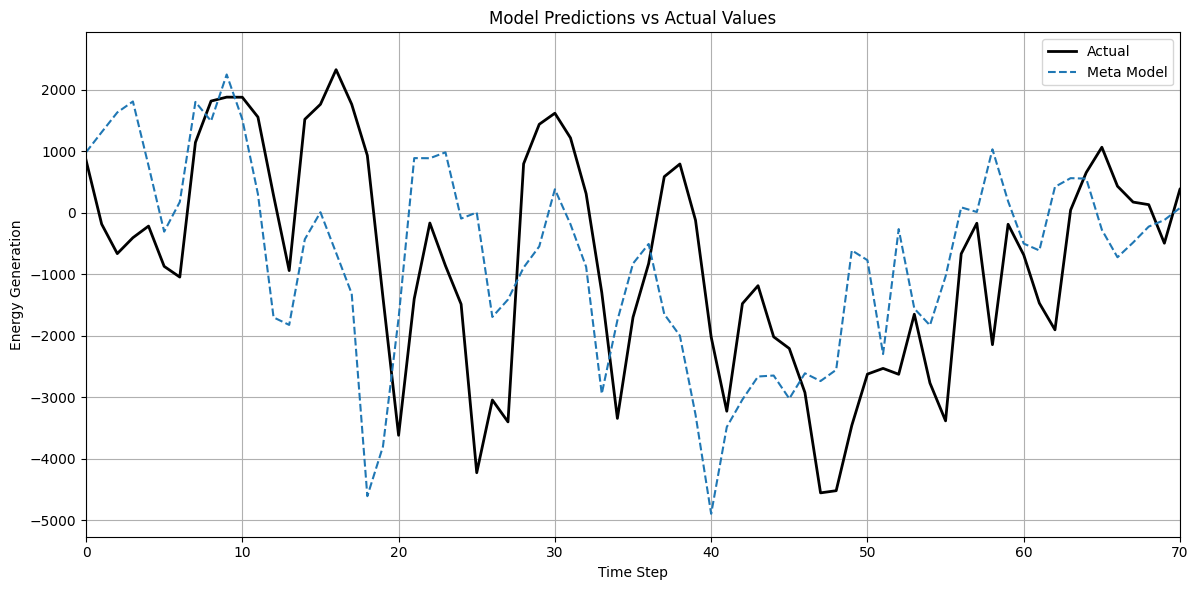

In [64]:
#Ploting data
y_true = y_test_final.reshape(-1)
meta_pred = meta_pred.reshape(-1)

y_true_orig = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
meta_pred = scaler.inverse_transform(meta_pred.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 6))

plt.plot(y_true_orig, label='Actual', color='black', linewidth=2)
plt.plot(meta_pred, label='Meta Model', linestyle='--')


plt.title('Model Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Energy Generation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(0, 70)
plt.show()